The goal of this notebook is to explore and learn more...bare with me ;)

The idea is to see if I can train a NLP machine learning model to develop a type of “intuition”  by training it with examples of positive and negative tweets. I would like to also use the test set to see if it is possible in detecting hidden emotion in otherwise neutral statements. An exploritory analysis on agressive words/statements found within neutral tweets could be interesting(exploring passive agressive behaviours). If a model sees many examples of possitive and negative sentiments, it should be able to recognize neutral statements that are not quite neutral along with identifying positive and negative Tweets when shown new data. 

Data Dictionary

Apple Twitter dataset contains the following fields:


*   _unit_id: a unique id for user
*   _golden: whether the user was included in the gold standard for the   model; TRUE or FALSE
*   _unit_state: state of the observation; one of finalized (for contributor-judged) or golden (for gold standard observations)
*   _trusted_judgments: number of trusted judgments (int); always 3 for non-golden, and what may be a unique id for gold standard observations
*   _last_judgment_at: date and time of last contributor judgment; blank for gold standard observations
*   sentiment:
*   sentiment:confidence: a float representing confidence in the provided sentiment
*   date: date of tweet
*   id: 
*   query:
*   sentiment_gold:
*   text: text of one of the user's tweets about apple




https://towardsdatascience.com/simple-twitter-analytics-with-twitter-nlp-toolkit-7d7d79bf2535

3886, 12

(1642, 3) after dropped columns & classification  

Neutral votes of 3 are ommited =2244= 

would be interesting to run an analysis on Neutral: 3/non_relevant 


if the analysis works. 


#Imports

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import random #SHOWS RANDOM VALUES/tweets
import re
import ast
import nltk
import spacy
import warnings
warnings.filterwarnings('ignore')
import pickle#### havent gotten there yet

from collections import Counter
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer  #https://machinelearningknowledge.ai/beginners-guide-to-stemming-in-python-nltk/
from nltk.tokenize import RegexpTokenizer, sent_tokenize, word_tokenize #DATA TOKENIZATION
from nltk.inference.tableau import Categories

from tensorflow.keras.preprocessing import text, sequence   #tokenize the dataset corpus, delete uncommon words such as names.
from tensorflow.keras.preprocessing.sequence import pad_sequences #rfc
from tensorflow.keras.utils import to_categorical
#for the SML model#######
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint
#################
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.models import load_model
from keras.callbacks import ModelCheckpoint  
from keras.utils.vis_utils import plot_model
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D

from IPython.display import display, HTML

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import precision_score, accuracy_score, f1_score,recall_score, roc_auc_score,precision_recall_curve, average_precision_score, auc, roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from wordcloud import WordCloud

from matplotlib import rcParams

sns.set()

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
cv = CountVectorizer(max_features = 5000, stop_words = 'english')
ps = PorterStemmer()
nlp = spacy.load('en_core_web_sm')

#Data

In [6]:
apple_twitter = pd.read_csv('/content/drive/MyDrive/Projects/project_2/Apple-Twitter-Sentiment-DFE.csv')

#EDA


In [7]:
apple_twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3886 entries, 0 to 3885
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   _unit_id              3886 non-null   int64  
 1   _golden               3886 non-null   bool   
 2   _unit_state           3886 non-null   object 
 3   _trusted_judgments    3886 non-null   int64  
 4   _last_judgment_at     3783 non-null   object 
 5   sentiment             3886 non-null   object 
 6   sentiment:confidence  3886 non-null   float64
 7   date                  3886 non-null   object 
 8   id                    3886 non-null   float64
 9   query                 3886 non-null   object 
 10  sentiment_gold        103 non-null    object 
 11  text                  3886 non-null   object 
dtypes: bool(1), float64(2), int64(2), object(7)
memory usage: 337.9+ KB


In [8]:
apple_twitter.isnull().sum()

_unit_id                   0
_golden                    0
_unit_state                0
_trusted_judgments         0
_last_judgment_at        103
sentiment                  0
sentiment:confidence       0
date                       0
id                         0
query                      0
sentiment_gold          3783
text                       0
dtype: int64

In [9]:
apple_twitter.nunique()

_unit_id                3886
_golden                    2
_unit_state                2
_trusted_judgments        19
_last_judgment_at        388
sentiment                  4
sentiment:confidence     654
date                    3795
id                         3
query                      1
sentiment_gold             9
text                    3217
dtype: int64

*  5 is positive, 3 is neutral and 1 is negative

*  tail is a better overview of the data.

In [10]:
apple_twitter.tail()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,date,id,query,sentiment_gold,text
3881,623499442,True,golden,13,NaN,3,0.7757,Tue Dec 09 22:08:53 +0000 2014,5.420000e+17,#AAPL OR @Apple,5\n3,(Via FC) Apple Is Warming Up To Social Media -...
3882,623499450,True,golden,16,NaN,3,0.6225,Tue Dec 09 22:18:27 +0000 2014,5.420000e+17,#AAPL OR @Apple,3\n1,RT @MMLXIV: there is no avocado emoji may I as...
3883,623499486,True,golden,14,NaN,5,0.9347,Tue Dec 09 23:45:59 +0000 2014,5.420000e+17,#AAPL OR @Apple,5,@marcbulandr I could not agree more. Between @...
3884,623499514,True,golden,13,NaN,1,0.9230,Wed Dec 10 00:48:10 +0000 2014,5.420000e+17,#AAPL OR @Apple,1,My iPhone 5's photos are no longer downloading...
3885,623517290,True,golden,17,NaN,5,0.8938,Tue Dec 09 09:01:25 +0000 2014,5.420000e+17,#AAPL OR @Apple,5\n3\nnot_relevant,RT @SwiftKey: We're so excited to be named to ...


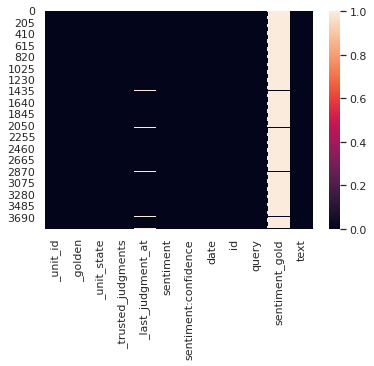

In [11]:
sns.heatmap(apple_twitter.isnull())

Text(0.5, 1.0, 'Correlation of numerical features(diagonal removed)')

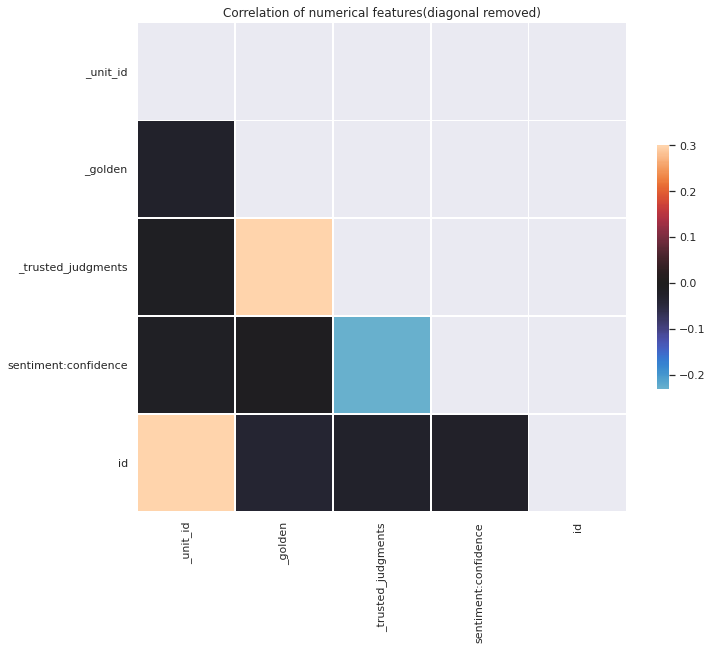

In [12]:

corr = apple_twitter.corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(corr, mask=mask, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax = plt.gca()
ax.set_title("Correlation of numerical features(diagonal removed)")

In [13]:


# Show random tweet examples
randomtwt = random.choice(apple_twitter['text'])
print( f'Random example tweet:\n{randomtwt}')

Random example tweet:
@Kate3015 @Apple get the new sony


In [14]:


apple_twitter['sentiment'].unique()

array(['3', '5', '1', 'not_relevant'], dtype=object)

In [15]:
begindate = min(apple_twitter['date'])
enddate = max(apple_twitter['date'])

##Visualizations 'sentiment' variable 

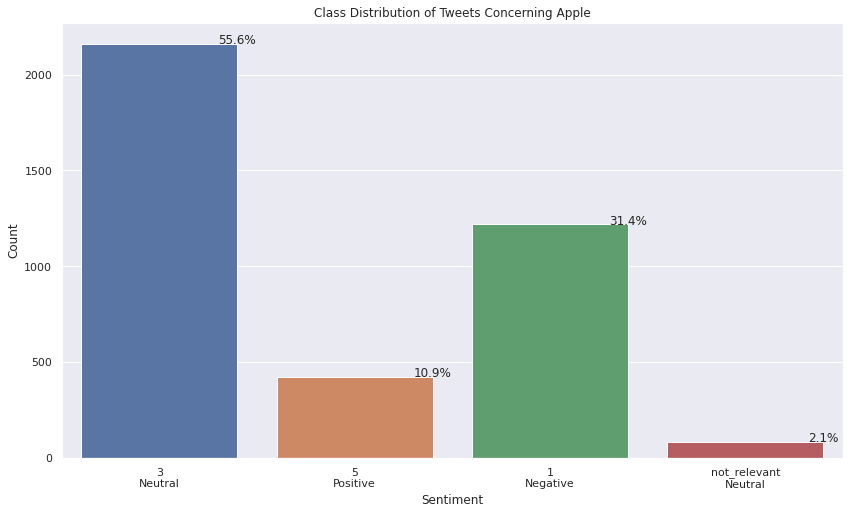

The dates of Tweets observed and classified before cleaning are
Fri Dec 05 00:02:35 +0000 2014 - Wed Dec 10 00:48:10 +0000 2014


In [16]:
plt.figure(figsize=(14,8))
total = float(len(apple_twitter))
ax = sns.countplot(x='sentiment', data=apple_twitter)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
    ax.set_title("Class Distribution of Tweets Concerning Apple")
    ax.set_xlabel("Sentiment")
    ax.set_ylabel("Count")
    ax.set_xticklabels(['3\nNeutral','5\nPositive','1\nNegative','not_relevant\nNeutral'])
plt.show()
print(f'The dates of Tweets observed and classified before cleaning are\n{begindate} - {enddate}')

In [17]:
counts = apple_twitter['sentiment'].value_counts()
print(f'Sentiment Classification of Tweets:\n3 & not_relevant: NEUTRAL\t3: NEGATIVE\t5: POSITIVE\n{counts}')

Sentiment Classification of Tweets:
3 & not_relevant: NEUTRAL	3: NEGATIVE	5: POSITIVE
3               2162
1               1219
5                423
not_relevant      82
Name: sentiment, dtype: int64


#Cleaning



The majority of Tweets have given neutral feedback. There is more Negative feedback than Neutral @Apple in Tweets
 
 main issue: class imbalance
 * neutral and not_relevant take up more than half of the dataset

 * negative tweets almost tripple the positive. 

###elimnating the non_relevant and neutral classes

the model will be training to recognize strong emotion using
 
   simple class encoder to get to 1s and 0s for each of the sentiment

In [18]:
apple_twitter = apple_twitter[apple_twitter['sentiment']!="3"]
apple_twitter = apple_twitter[apple_twitter['sentiment']!='not_relevant']
apple_twitter = apple_twitter.reset_index()

In [19]:
apple_twitter.head()

,index,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,date,id,query,sentiment_gold,text
0,6,623495519,True,golden,13,NaN,5,0.8468,Mon Dec 01 20:32:45 +0000 2014,5.400000e+17,#AAPL OR @Apple,5,Top 3 all @Apple #tablets. Damn right! http://...
1,7,623495520,True,golden,9,NaN,5,0.6736,Mon Dec 01 20:34:31 +0000 2014,5.400000e+17,#AAPL OR @Apple,5\n3,CNBCTV: #Apple's margins better than expected?...
2,10,623495523,True,golden,12,NaN,1,1.0000,Mon Dec 01 20:46:01 +0000 2014,5.400000e+17,#AAPL OR @Apple,1,WTF MY BATTERY WAS 31% ONE SECOND AGO AND NOW ...
3,13,623495526,False,finalized,3,12/12/14 21:38,5,1.0000,Mon Dec 01 21:03:32 +0000 2014,5.400000e+17,#AAPL OR @Apple,NaN,RT @peterpham: Bought my @AugustSmartLock at t...
4,14,623495527,True,golden,17,NaN,1,1.0000,Mon Dec 01 21:09:50 +0000 2014,5.400000e+17,#AAPL OR @Apple,1,@apple Contact sync between Yosemite and iOS8 ...


In [20]:
apple_twitter.shape

(1642, 13)

In [21]:
def encoder(x):
    if x=='5':
        return 1
    else:
        return 0
apple_twitter['sentiment'] = apple_twitter['sentiment'].apply(encoder)

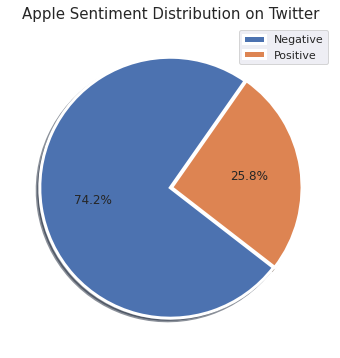

In [22]:
plt.figure(figsize=(6, 6))
explode = [0, 0.01]
plt.pie(apple_twitter['sentiment'].value_counts(), explode=explode, autopct='%1.1f%%', shadow=True, startangle=55, wedgeprops = {'linewidth': 3})
plt.legend(labels=[ 'Negative','Positive'])
plt.title('Apple Sentiment Distribution on Twitter', fontsize=15)
plt.axis('off');

* The dates of Tweets observed and classified before cleaning are
>* Fri Dec 05 00:02:35 +0000 2014 - Wed Dec 10 00:48:10 +0000 2014
* The dates of Tweets observed and classified after cleaning are
>* Fri Dec 05 00:02:59 +0000 2014 - Wed Dec 10 00:48:10 +0000 2014

In [23]:
# The dates of Tweets observed and classified before cleaning are
# Fri Dec 05 00:02:35 +0000 2014 - Wed Dec 10 00:48:10 +0000 2014
# The dates of Tweets observed and classified after cleaning are
# Fri Dec 05 00:02:59 +0000 2014 - Wed Dec 10 00:48:10 +0000 2014
# begindate = min(apple_twitter2['date'])
# enddate = max(apple_twitter2['date'])
# print(f'The dates of Tweets observed and classified before cleaning are\n{begindate} - {enddate}')

In [24]:
apple_twitter.head(3)

,index,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,date,id,query,sentiment_gold,text
0,6,623495519,True,golden,13,NaN,1,0.8468,Mon Dec 01 20:32:45 +0000 2014,5.400000e+17,#AAPL OR @Apple,5,Top 3 all @Apple #tablets. Damn right! http://...
1,7,623495520,True,golden,9,NaN,1,0.6736,Mon Dec 01 20:34:31 +0000 2014,5.400000e+17,#AAPL OR @Apple,5\n3,CNBCTV: #Apple's margins better than expected?...
2,10,623495523,True,golden,12,NaN,0,1.0000,Mon Dec 01 20:46:01 +0000 2014,5.400000e+17,#AAPL OR @Apple,1,WTF MY BATTERY WAS 31% ONE SECOND AGO AND NOW ...


##one way

###dropping columns that have no relevance for this analysis

In [25]:
apple_twitter.shape

(1642, 13)

In [26]:
apple_twitter2 = apple_twitter.drop(['_unit_id', '_golden', '_unit_state', '_trusted_judgments', '_last_judgment_at', 'date','id','query', 'sentiment_gold', 'sentiment:confidence'],axis = 1)

In [27]:
apple_twitter2.shape==apple_twitter.shape

False

In [28]:
apple_twitter2.tail()

,index,sentiment,text
1637,3878,1,RT @shannonmmiller: Love the @Apple is support...
1638,3880,0,hey @apple is it normal for my laptop charger ...
1639,3883,1,@marcbulandr I could not agree more. Between @...
1640,3884,0,My iPhone 5's photos are no longer downloading...
1641,3885,1,RT @SwiftKey: We're so excited to be named to ...


###1st preprocessing of text 

Replace punctuation and special characters not helpful to analysis or meaningful


Symbols to be removed:

   *  url symbols (http:)
   * Twitter symbols (@, #)

creating a new dataframe(clean_at) to preserve the original text

In [29]:
def preprocess(text):
    '''Replaces various punctuation and special characters not helpful to analysis or meaningful'''
    text = text.str.replace('(<br/>)', '', regex=True)
    text = text.str.replace('(<a).*(>).*(</a>)', '', regex=True)
    text = text.str.replace('(&amp)', '', regex=True)
    text = text.str.replace('(&gt)', '', regex=True)
    text = text.str.replace('(&lt)', '', regex=True)
    text = text.str.replace('(\xa0)', '', regex=True)
    text = text.str.replace('#','', regex=True)    
    text = text.str.replace('@','', regex=True)
    text = text.str.replace('@\S+', '', regex=True)
    text = text.str.replace('http\S+', '', regex=True) 
    text = text.str.replace('http:', '', regex=True) 
    text = text.str.replace("'",'', regex=True)
    text = text.str.replace(',','', regex=True)
    text = text.str.replace('{', '', regex=True)
    text = text.str.replace('}', '', regex=True)
    text = text.str.replace('.', '', regex=True)
    text = text.str.replace(':', '', regex=True)
    text = text.str.replace('-', '', regex=True)
    text = text.str.replace('rt', '', regex=True)
    text = text.str.replace('(\b[0-9]{2,}\b)','', regex=True)
    text = text.str.lower()
    return text

clean_at = apple_twitter2
clean_at['text'] = preprocess(clean_at['text'])

clean_at['text']

0                    top 3 all apple tablets damn right! 
1       cnbctv apples margins better than expected? aapl 
2       wtf my battery was 31% one second ago and now ...
3       rt peterpham bought my augustsmalock at the ap...
4       apple contact sync between yosemite and ios8 i...
                              ...                        
1637    rt shannonmmiller love the apple is suppoing h...
1638    hey apple is it normal for my laptop charger t...
1639    marcbulandr i could not agree more between app...
1640    my iphone 5s photos are no longer downloading ...
1641    rt swiftkey were so excited to be named to app...
Name: text, Length: 1642, dtype: object

In [30]:
clean_at.to_csv('clean_apple.csv')

In [31]:
clean_at.head()

,index,sentiment,text
0,6,1,top 3 all apple tablets damn right!
1,7,1,cnbctv apples margins better than expected? aapl
2,10,0,wtf my battery was 31% one second ago and now ...
3,13,1,rt peterpham bought my augustsmalock at the ap...
4,14,0,apple contact sync between yosemite and ios8 i...


In [32]:
clean_at.shape==apple_twitter.shape

False

In [33]:
def tweet_special_count(string, character):
    '''Splits string by word, and returns the count of a given character starting a tweet'''
    w = string.split()    
    char = [word for word in w if word.startswith(character)]    
    return len(char)

Creating new features out counts of the data. for future analysis and learning

In [34]:


#gathering length of each tweet's string into feature
clean_at['tweet_len'] = clean_at['text'].astype(str).apply(len)

#splitting length to derive word count
clean_at['tweet_words'] = clean_at['text'].apply(lambda x: len(str(x).split()))

#applying tweet_special count on hashtags and mentions(@)
clean_at['hash_cnt'] = clean_at['text'].apply(lambda x: tweet_special_count(x, '#'))
clean_at['mention_cnt'] = clean_at['text'].apply(lambda x: tweet_special_count(x, '@'))

#use of regex to identify capital letters starting a word group and exclamation/question marks
clean_at['capital_words'] = clean_at['text'].apply(lambda x: len(re.findall(r'\b[A-Z]{2,}\b', x)))
clean_at['excl_q_marks'] = clean_at['text'].apply(lambda x: len(re.findall(r'!|\?', x)))
clean_at['numbers'] = clean_at['text'].apply(lambda x: len(re.findall(r'\b[0-9]{2,}\b', x)))
#takes length of split words and calculates mean word length
clean_at["mean_word_len"] = clean_at["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

#length of the Python Set of a split string to derive unique words' count
clean_at['count_unique_word']=clean_at["text"].apply(lambda x: len(set(str(x).split())))

#count of unique words within a tweet
clean_at['word_unique_percent']=clean_at['count_unique_word']*100/clean_at['tweet_words']

clean_at.head()

,index,sentiment,text,tweet_len,tweet_words,hash_cnt,mention_cnt,capital_words,excl_q_marks,numbers,mean_word_len,count_unique_word,word_unique_percent
0,6,1,top 3 all apple tablets damn right!,36,7,0,0,0,1,0,4.142857,7,100.0
1,7,1,cnbctv apples margins better than expected? aapl,49,7,0,0,0,1,0,6.000000,7,100.0
2,10,0,wtf my battery was 31% one second ago and now ...,70,16,0,0,0,0,2,3.437500,14,87.5
3,13,1,rt peterpham bought my augustsmalock at the ap...,104,17,0,0,0,1,0,5.058824,17,100.0
4,14,0,apple contact sync between yosemite and ios8 i...,124,23,0,0,0,0,0,4.434783,23,100.0


###tokenizing 

Spacy's default parser for NER(Named Entity Recognition)

splits(tokenizes) the sentence into words(tokens) and keeps the most common words
creating an indexed dictionary of the words ranked in order of frequency
https://en.wikipedia.org/wiki/SpaCy

In [35]:
tokens = nlp(''.join(str(clean_at.text.tolist())))

###extracting items with entities in their tokens and displaying the 20 most commmon

In [36]:
items = [x.text for x in tokens.ents]
Counter(items).most_common(20)

[('4', 79),
 ('45000 ft  one', 72),
 ('6', 54),
 ('today', 25),
 ('nyc', 25),
 ('2', 19),
 ('5', 18),
 ('2014', 16),
 ('iphone6', 13),
 ('3', 12),
 ('8', 11),
 ('monday', 11),
 ('first', 11),
 ('one', 11),
 ('ios8', 10),
 ('5s', 9),
 ('fazenikan', 8),
 ('harry potter', 8),
 ('this year', 8),
 ('safari', 7)]

###NLTK tokenizer

In [37]:
tokenizer = RegexpTokenizer(r'\w+')
clean_at['tokens'] = clean_at['text'].apply(tokenizer.tokenize)

In [38]:
clean_at['tokens'][42]

['apple', 'why', 'was', 'the', 'iphone', '4', 'ever', 'created']

In [39]:
clean_at.head()

,index,sentiment,text,tweet_len,tweet_words,hash_cnt,mention_cnt,capital_words,excl_q_marks,numbers,mean_word_len,count_unique_word,word_unique_percent,tokens
0,6,1,top 3 all apple tablets damn right!,36,7,0,0,0,1,0,4.142857,7,100.0,"[top, 3, all, apple, tablets, damn, right]"
1,7,1,cnbctv apples margins better than expected? aapl,49,7,0,0,0,1,0,6.000000,7,100.0,"[cnbctv, apples, margins, better, than, expect..."
2,10,0,wtf my battery was 31% one second ago and now ...,70,16,0,0,0,0,2,3.437500,14,87.5,"[wtf, my, battery, was, 31, one, second, ago, ..."
3,13,1,rt peterpham bought my augustsmalock at the ap...,104,17,0,0,0,1,0,5.058824,17,100.0,"[rt, peterpham, bought, my, augustsmalock, at,..."
4,14,0,apple contact sync between yosemite and ios8 i...,124,23,0,0,0,0,0,4.434783,23,100.0,"[apple, contact, sync, between, yosemite, and,..."


In [40]:
clean_at.sum()

index                                                            3165945
sentiment                                                            423
text                   top 3 all apple tablets damn right! cnbctv app...
tweet_len                                                         139101
tweet_words                                                        24938
hash_cnt                                                               0
mention_cnt                                                            0
capital_words                                                          0
excl_q_marks                                                         992
numbers                                                              288
mean_word_len                                                7717.580543
count_unique_word                                                  23790
word_unique_percent                                        158297.428957
tokens                 [top, 3, all, apple, tablets

In [41]:
clean_at.describe()

,index,sentiment,tweet_len,tweet_words,hash_cnt,mention_cnt,capital_words,excl_q_marks,numbers,mean_word_len,count_unique_word,word_unique_percent
count,1642.000000,1642.000000,1642.000000,1642.000000,1642.0,1642.0,1642.0,1642.000000,1642.000000,1642.000000,1642.000000,1642.000000
mean,1928.102923,0.257613,84.714373,15.187576,0.0,0.0,0.0,0.604141,0.175396,4.700110,14.488429,96.405255
std,1106.875784,0.437453,31.859945,6.064363,0.0,0.0,0.0,1.233963,0.448089,0.798430,5.480467,5.122938
min,6.000000,0.000000,10.000000,2.000000,0.0,0.0,0.0,0.000000,0.000000,2.800000,2.000000,68.181818
25%,954.000000,0.000000,60.000000,11.000000,0.0,0.0,0.0,0.000000,0.000000,4.154858,10.000000,94.117647
50%,2013.500000,0.000000,87.000000,15.000000,0.0,0.0,0.0,0.000000,0.000000,4.604348,14.500000,100.000000
75%,2829.750000,1.000000,110.000000,19.000000,0.0,0.0,0.0,1.000000,0.000000,5.111111,18.000000,100.000000
max,3885.000000,1.000000,139.000000,29.000000,0.0,0.0,0.0,12.000000,3.000000,8.600000,29.000000,100.000000


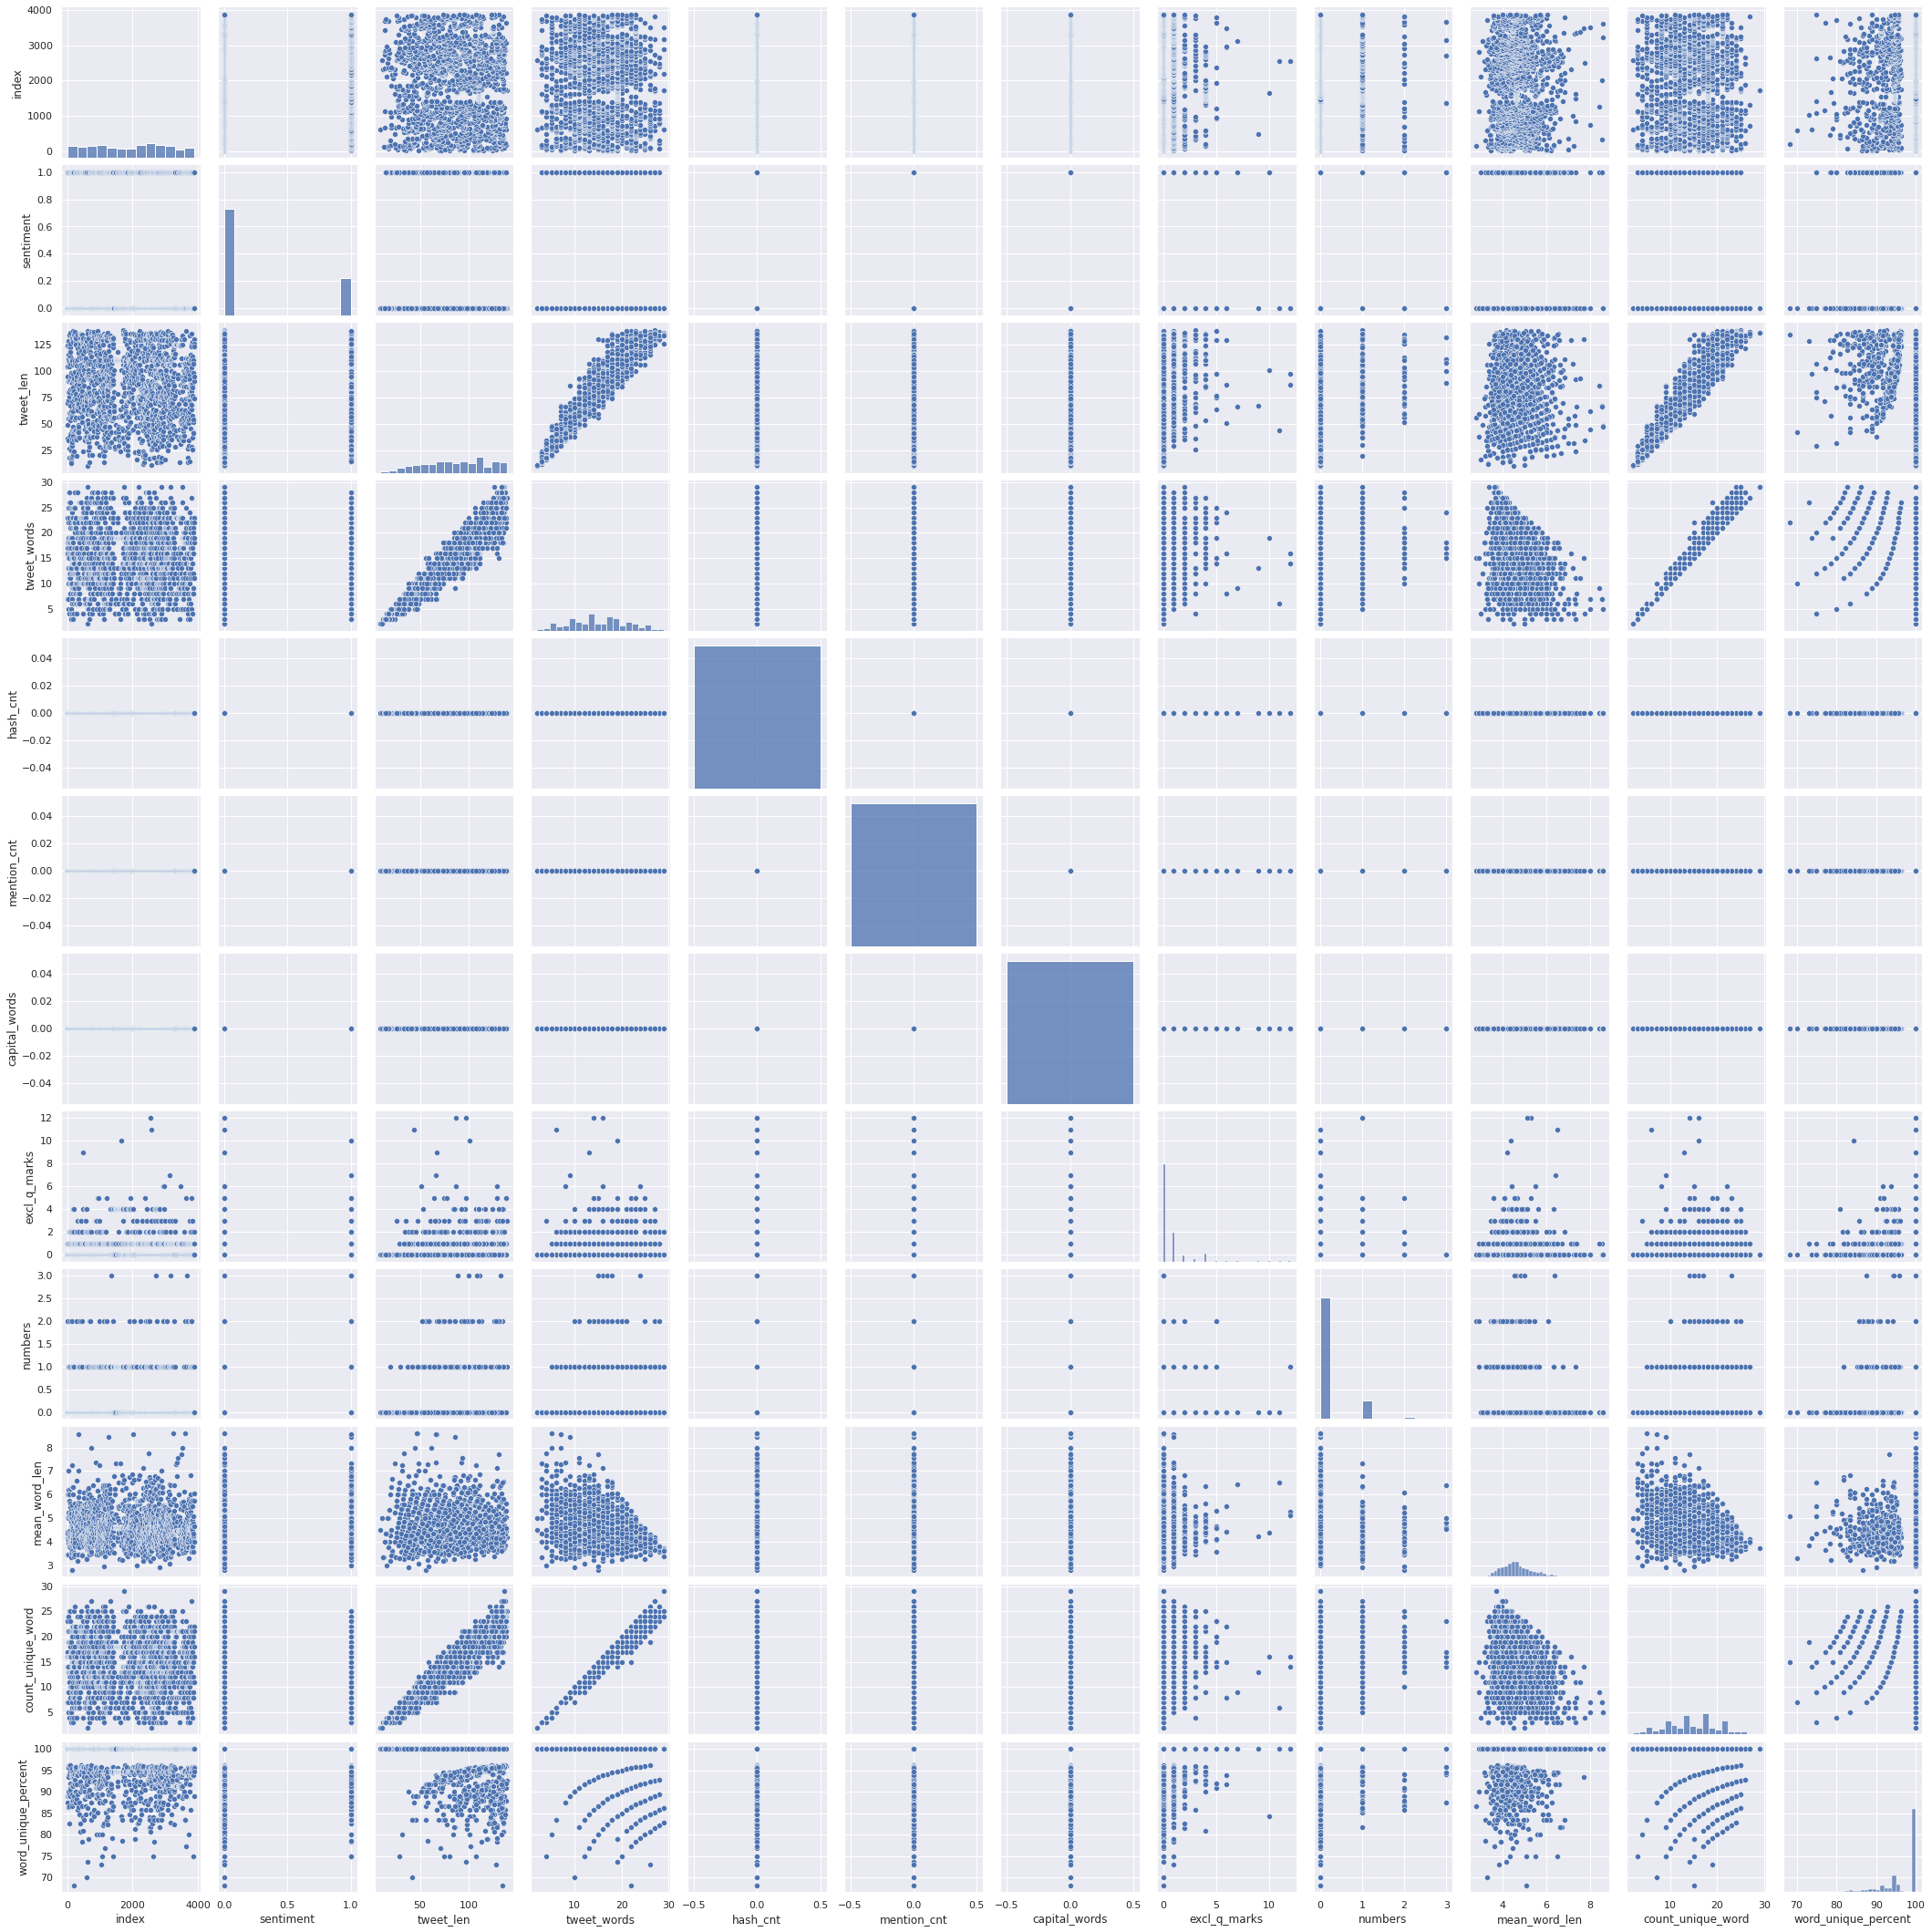

In [42]:
sns.pairplot(clean_at)

##second using lemmitizer

In [43]:
at_c2 = apple_twitter2

In [44]:
at_c2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642 entries, 0 to 1641
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   index                1642 non-null   int64  
 1   sentiment            1642 non-null   int64  
 2   text                 1642 non-null   object 
 3   tweet_len            1642 non-null   int64  
 4   tweet_words          1642 non-null   int64  
 5   hash_cnt             1642 non-null   int64  
 6   mention_cnt          1642 non-null   int64  
 7   capital_words        1642 non-null   int64  
 8   excl_q_marks         1642 non-null   int64  
 9   numbers              1642 non-null   int64  
 10  mean_word_len        1642 non-null   float64
 11  count_unique_word    1642 non-null   int64  
 12  word_unique_percent  1642 non-null   float64
 13  tokens               1642 non-null   object 
dtypes: float64(2), int64(10), object(2)
memory usage: 179.7+ KB


In [45]:
lemmatizer = WordNetLemmatizer()

In [46]:
def get_simple_pos(tag):
    if tag.startswith('N') or tag.startswith('J'):
        return wordnet.NOUN
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [47]:
def clean_tweets(text):
    clean_words=[]
    # Remove email addresses patterns 
    raw_text = re.sub('\b[\w\-.]+?@\w+?\w+?\.\w{2,4}\b',' ', text)
    # Remove web addresses patterns 
    raw_text = re.sub('\b[\w\-.]+?@\w+?\w+?\.\w{2,4}\b',' ', text)
    raw_text = re.sub('^https?:\/\/.*[\r\n]*',' ', text)
    raw_text = re.sub('http','', text)
    # Remove URLs  patterns
    raw_text =re.sub('[^a-zA-Z-z0-9\s]',' ', raw_text)
    # Remove numbers
    raw_text= re.sub('\d+(\.\d+)?',' ', raw_text)

    stop_words=set(stopwords.words("english"))
    words_tokens= nltk.word_tokenize(raw_text)  
    for word in words_tokens :

      if word.lower() not in stop_words:
        pos = pos_tag([word]) # get the part of speech of each word 
    
        clean_word=(lemmatizer.lemmatize(word.lower(), pos=get_simple_pos(tag)) for word, tag in pos)
        clean_words.append(''.join(clean_word))

    return (' '.join(clean_words))

###store the cleaned tweets inside clean_tweets_corpus array 

need to read

In [48]:
clean_tweets_corpus = []

for index, text in enumerate(at_c2['text']):
  clean_tweets_corpus.append(clean_tweets(at_c2['text'][index]))

In [49]:
at_c2['text'] = at_c2['text'].apply(clean_tweets)
at_c2['text'].head()

0                          top apple tablet damn right
1                 cnbctv apple margin well expect aapl
2                 wtf battery one second ago wtf apple
3    rt peterpham bought augustsmalock apple storep...
4    apple contact sync yosemite io seriously screw...
Name: text, dtype: object

###tokenizing 
Spacy's default parser for NER(Named Entity Recognition)
ideal for the movie test set much larger
read and look into others

In [50]:
tokens = nlp(''.join(str(at_c2.text.tolist())))

###Extrating tokens with entitys

displaying the 20 most commmon

In [51]:

items = [x.text for x in tokens.ents]
Counter(items).most_common(20)

[('one', 98),
 ('today', 26),
 ('monday', 11),
 ('first', 11),
 ('tim', 10),
 ('steve', 9),
 ('fazenikan', 8),
 ('year', 8),
 ('harry potter', 8),
 ('month', 6),
 ('hour', 6),
 ('safari', 6),
 ('second', 5),
 ('yesterday', 5),
 ('two', 5),
 ('week', 5),
 ('japan', 5),
 ('mark zuckerberg', 5),
 ('tim cook', 4),
 ('microsoft', 4)]

In [52]:
at_c2.tail()

,index,sentiment,text,tweet_len,tweet_words,hash_cnt,mention_cnt,capital_words,excl_q_marks,numbers,mean_word_len,count_unique_word,word_unique_percent,tokens
1637,3878,1,rt shannonmmiller love apple suppoing hourofco...,74,11,0,0,0,1,0,5.727273,11,100.000000,"[rt, shannonmmiller, love, the, apple, is, sup..."
1638,3880,0,hey apple normal laptop charger solder skin th...,90,18,0,0,0,2,0,4.000000,16,88.888889,"[hey, apple, is, it, normal, for, my, laptop, ..."
1639,3883,1,marcbulandr could agree apple twitter ibmwatso...,126,18,0,0,0,0,0,6.055556,18,100.000000,"[marcbulandr, i, could, not, agree, more, betw..."
1640,3884,0,iphone photo longer download automatically lap...,123,22,0,0,0,1,0,4.636364,21,95.454545,"[my, iphone, 5s, photos, are, no, longer, down..."
1641,3885,1,rt swiftkey excite name apple app store best l...,95,19,0,0,0,1,1,4.000000,18,94.736842,"[rt, swiftkey, were, so, excited, to, be, name..."


In [53]:
# text 42 cleaned  
print("tweet 42 cleaned {",at_c2['text'][42],"}")

tweet 42 cleaned { apple iphone ever create }


In ommitting the numbers iphone model numbers will be eliminated... Apple and iphone in general should be eliminated in that they are names. 

Go back and use a larger data set to train the model as that small data sets can be overfitted



In [54]:
words_values = pd.Series(" ".join(at_c2['text']).split()).value_counts()
print(words_values)

apple          1726
rt              275
aapl            230
iphone          226
phone           155
               ... 
contributor       1
bi                1
entire            1
cynic             1
unhelpful         1
Length: 3423, dtype: int64


In [55]:
words_values = pd.Series(" ".join(at_c2['text']).split()).value_counts()
print(words_values)
rare_words = words_values[words_values <= 3]
print(rare_words)
print(rare_words.value_counts())

apple          1726
rt              275
aapl            230
iphone          226
phone           155
               ... 
contributor       1
bi                1
entire            1
cynic             1
unhelpful         1
Length: 3423, dtype: int64
fails           3
azakfeverafc    3
travel          3
quick           3
beating         3
               ..
contributor     1
bi              1
entire          1
cynic           1
unhelpful       1
Length: 2699, dtype: int64
1    1944
2     511
3     244
dtype: int64


In [56]:
at_c2['text'] = at_c2['text'].apply(lambda x: " ".join([i for i in x.split() if i not in rare_words.index]))
at_c2['text'].head()

0                          top apple tablet damn right
1                               cnbctv apple well aapl
2                 wtf battery one second ago wtf apple
3         rt bought apple good match cant wait install
4    apple contact sync yosemite io seriously screw...
Name: text, dtype: object

###Visualizations 
WordCloud 

In [57]:
def create_WordCloud(data, back_ground_color="black", title=None):
  wordcloud = WordCloud(background_color=back_ground_color, max_words=400, max_font_size=40, scale=2, random_state=2).generate(str(data))
  plt.rcParams['figure.figsize']=(15,15) 
  mpl.rcParams['font.size']=16  
  #plt.style.use('fast')
  fig = plt.figure(1)
  if title:
    plt.title(title, fontsize=30)

  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

###catagorizing the pos and neg words 


> names and proper nouns still need removed. not sure if rt also needs to be removed. rt=rtweet
> back to need a larger data set




In [58]:
#Negative_words = " ".join(data[at_c2['text']  =="0"]in categories).split()
categories=at_c2.sentiment
Negative_words=[]
Positive_words=[]


#clean_tweets(at_c2['text'][index]
for index, num  in enumerate (categories):
    if num == 1:
        Positive_words.append(at_c2['text'][index])
    else :
        Negative_words.append(at_c2['text'][index])

In [59]:
Counter(items)

Counter({'one second ago': 1,
         'prob': 1,
         'rwang apple': 1,
         'today': 26,
         'woh measly': 1,
         'nsa': 2,
         'apple': 2,
         'wilson': 1,
         'month': 6,
         'baba': 1,
         'monday': 11,
         'ibm': 1,
         'hour': 6,
         'tday': 1,
         'chuck mikolajczak': 1,
         "new york reuters'": 1,
         "alex cho'": 1,
         'chaptersindigo': 1,
         'tonight': 3,
         'second': 5,
         'netflix': 1,
         'tim cook': 4,
         'one': 98,
         'season': 1,
         'thisdueemarco apple': 1,
         'first': 11,
         'yesterday': 5,
         'edtech': 3,
         'trillion dollar': 1,
         "jim breyer aapl'": 1,
         "tuesday december'": 1,
         "fuckin phone'": 1,
         "dazzler aapl'": 1,
         "iphones mac'": 1,
         'billion': 3,
         'california': 1,
         'safari': 6,
         'tim': 10,
         'chinese': 3,
         'rt elmetifi': 1,
        

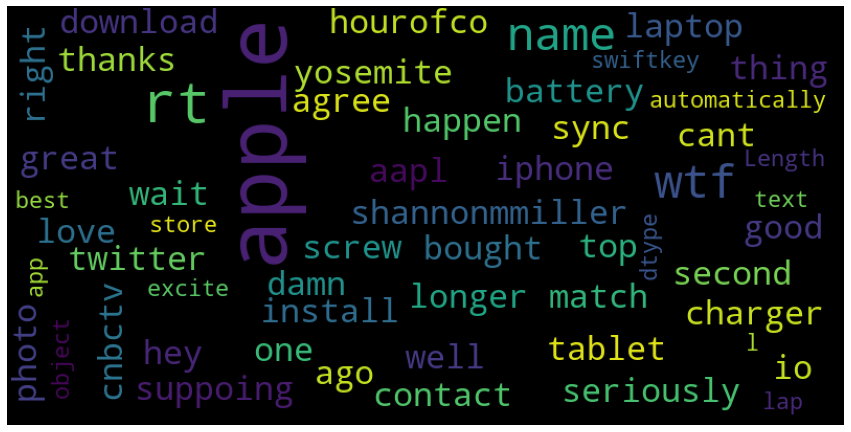

In [60]:
create_WordCloud(at_c2['text'])

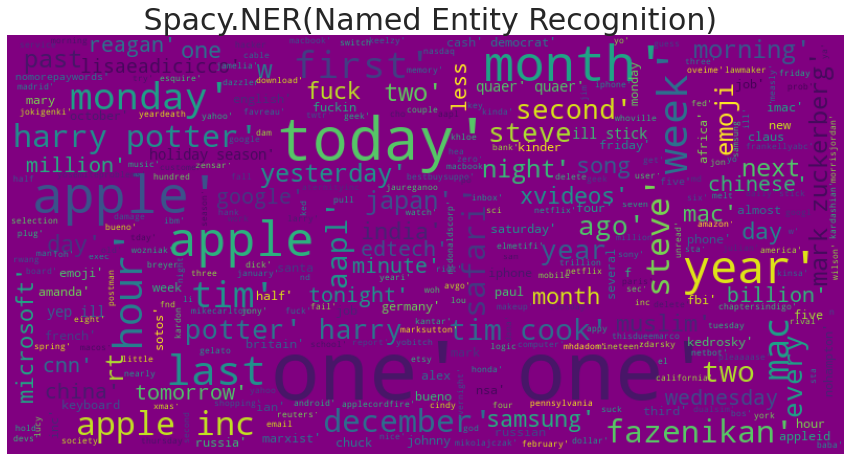

In [61]:
create_WordCloud(items, back_ground_color = "purple", title = " Spacy.NER(Named Entity Recognition)")

In [62]:
freq_neg=nltk.FreqDist(Negative_words)
top10neg = freq_neg.most_common(10)
print (f'The top 10 most common words associated with a Negative tweet are:\n{top10neg}')

The top 10 most common words associated with a Negative tweet are:
[('rt onerepublic studio ft one outlet computer apple need battery future', 71), ('rt teamcavuto protester stage diein protest apple store nyc anger misplace retweet agree', 12), ('fuck apple', 10), ('rt cruci btch dont harry potter emojis please work apple', 7), ('block trade detect aapl', 6), ('happy monday camera fancy apple iphone plus suddenly stop work weekend instead meme', 6), ('apple', 5), ('rt ilovemymom ive try turn whats problem apple', 5), ('rt laura kate group message people apple', 4), ('rt vito sfam hey apple battery iphone drop like cock see gay porn xvideos main page fix shit', 4)]


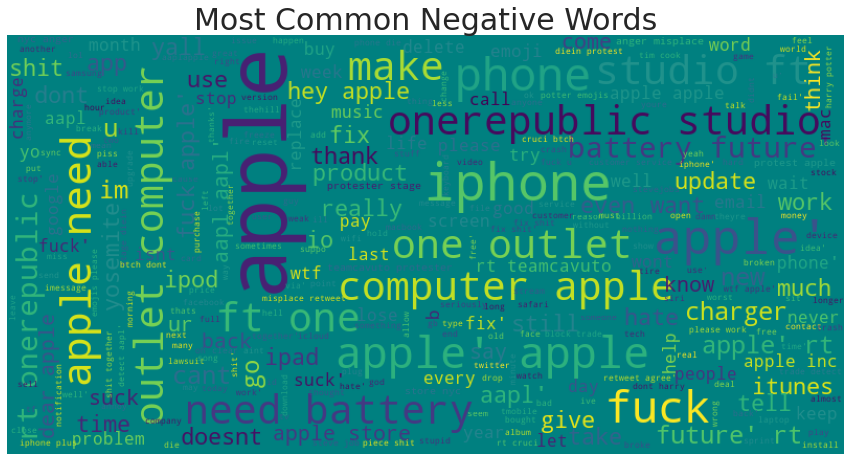

In [63]:
create_WordCloud(Negative_words, back_ground_color = "teal", title = "Most Common Negative Words")

In [64]:
freq_pos = nltk.FreqDist(Positive_words)
top10pos = freq_pos.most_common(15)
print (f'The top 10 most common words associated with a Positive tweet are:\n{top10neg}')

The top 10 most common words associated with a Positive tweet are:
[('rt onerepublic studio ft one outlet computer apple need battery future', 71), ('rt teamcavuto protester stage diein protest apple store nyc anger misplace retweet agree', 12), ('fuck apple', 10), ('rt cruci btch dont harry potter emojis please work apple', 7), ('block trade detect aapl', 6), ('happy monday camera fancy apple iphone plus suddenly stop work weekend instead meme', 6), ('apple', 5), ('rt ilovemymom ive try turn whats problem apple', 5), ('rt laura kate group message people apple', 4), ('rt vito sfam hey apple battery iphone drop like cock see gay porn xvideos main page fix shit', 4)]


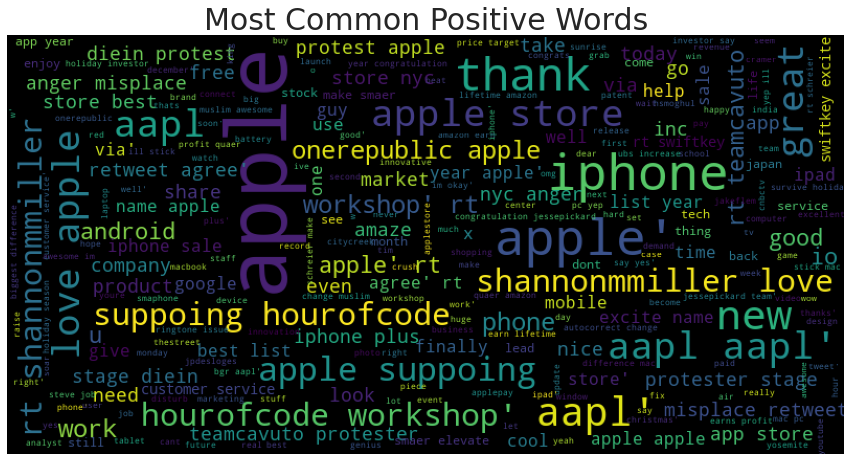

In [65]:
create_WordCloud(Positive_words, back_ground_color = "black", title = "Most Common Positive Words")

There are still propper nouns and other words in the data that have no sentiment value. Needs cleaned further. only good for advertisement purposes/graphics

###TrainTestSplit & vectorize

In [66]:

x_train, x_test, y_train, y_test = train_test_split(at_c2['text'], categories, stratify=categories, test_size=0.10, random_state=3)

###Vectorization

In [67]:
count_vec=CountVectorizer(ngram_range=(1,2))

In [68]:
x_train_features=count_vec.fit_transform(x_train)
x_train_features=x_train_features.toarray()

In [69]:
x_train_features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [70]:
x_test_features=count_vec.transform(x_test)

In [71]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))
x_train_tfidf=tfidf_vectorizer.fit_transform(x_train)
x_test_tfidf=tfidf_vectorizer.transform(x_test)

In [72]:
feature_names = tfidf_vectorizer.get_feature_names()
feature_names[9]

'aapl crash'

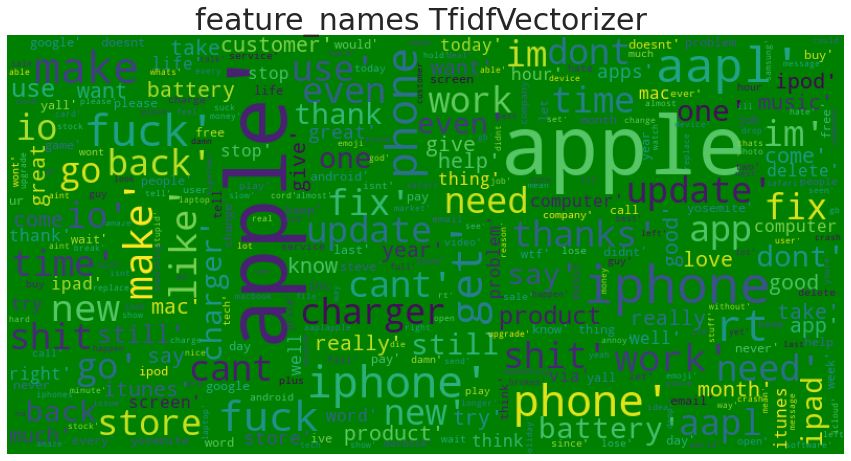

In [73]:
create_WordCloud(feature_names, back_ground_color = "green", title = "feature_names TfidfVectorizer ")

In [74]:
x_train_tfidf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [75]:
x_test_tfidf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

ndarrayERRORS ERRORS ERRORS. changed it to array... 
https://stackoverflow.com/questions/4151128/what-are-the-differences-between-numpy-arrays-and-matrices-which-one-should-i-u

In [76]:
batch_size = 101
epochs = 4

simple_nn = Sequential()
simple_nn.add(Dense(150, activation='relu', input_shape=(119,)))
simple_nn.add(Dropout(0.2))
simple_nn.add(Dense(100, activation='relu'))
simple_nn.add(Dropout(0.2))
simple_nn.add(Dense(1, activation='sigmoid'))

simple_nn.summary()

simple_nn.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

checkpoint = ModelCheckpoint('./', monitor = 'val_accuracy', verbose = 1, save_best_only=True)
history = simple_nn.fit(x_train.todense(), y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks = [checkpoint],
                    validation_data=(x_test.todense(), y_test))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 150)               18000     
                                                                 
 dropout (Dropout)           (None, 150)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               15100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 33,201
Trainable params: 33,201
Non-trainable params: 0
_________________________________________________________________


AttributeError: ignored

# Deep Learning Model...
used most of amazon notebook
... looking for another one now

https://deepai.org/publication/training-deep-learning-models-with-small-datasets

In [ ]:
max_len = max(x_train, key = len)
print(f'Maximum number of words in a tweet in training data:\n{len(max_len)}')

In [ ]:
# Convert Tweets to padded sequences
max_words = 101
tokenizer = Tokenizer(num_words = max_words)

In [ ]:
# create the vocabulary by fitting on X_train text
tokenizer.fit_on_texts(x_train)

In [ ]:
# get the sequence of tokens
xtrain_seq = tokenizer.texts_to_sequences(x_train)
xtest_seq = tokenizer.texts_to_sequences(x_test)

In [ ]:
# padding the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=len(max_len))
xtest_pad = sequence.pad_sequences(xtest_seq, maxlen=len(max_len))
word_index = tokenizer.word_index

In [ ]:
# get a random example
print('train tweet num 9:', x_train[8])
print('before padding:', xtrain_seq[8])
print('after padding:', xtrain_pad[8])

In [ ]:
# data shape after padding
print(xtrain_pad.shape)
print(xtest_pad.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
def create_model():
    model = tf.keras.models.Sequential([tf.keras.layers.Embedding(max_words, 100, input_length=max_words),
                                        tf.keras.layers.Conv1D(filters = 32, kernel_size = 2, padding ='same', activation='relu'),
                                        tf.keras.layers.MaxPooling1D(pool_size = 2),
                                        tf.keras.layers.LSTM(256),
                                        tf.keras.layers.Dense(1, activation='sigmoid')])
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(3e-4), metrics=['accuracy'])
    return model

In [ ]:
model = create_model()
model.summary()

In [ ]:
# print the block diagram of our model
plot_model(model, show_shapes = True, show_layer_names = True)

In [ ]:
# create model checkpoint and callbacks to save the model weights when validation accuracy is maximum
callback=tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 2, verbose = 2, mode = 'auto', baseline = None, restore_best_weights = True)

In [ ]:
device = tf.test.gpu_device_name()
if device != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device))

In [ ]:
# fit the model
with tf.device('/device:GPU:0'):
    history = model.fit(xtrain_pad, y_train, validation_data = (xtest_pad, y_test), class_weight = {0:87, 1:13}, epochs = 10, batch_size = 32)

In [ ]:

# predict probabilities for test set
y_probs = model.predict(xtest_pad, verbose = 0)

In [ ]:
# predict classes for test set
y_classes = (model.predict(xtest_pad) > 0.5).astype("int32")
y_train_pred=(model.predict(xtrain_pad) >= 0.5).astype("int32")

In [ ]:
# Model evaluation 
train_nn_results = model.evaluate(xtrain_pad, y_train, verbose=0)
test_nn_results = model.evaluate(xtest_pad, y_test, verbose=0)
print(f'Train accuracy: {train_nn_results[1]*100:0.2f}')
print(f'Test accuracy: {test_nn_results[1]*100:0.2f}')

In [ ]:
model.save('my_model.h5')

In [ ]:
# custom Tweets will be use later to compare the models 
Tweet_1 = 'Its not the best apple iphone.'
Tweet_2 = "i the mac pro was always better. this device is useless "
Tweet_3 = "customer service sucks these days"
Tweet_4 = "Thank you so much amazing!"
Tweet_5 = "Love it! Best phone I ever had. "
Tweet_6 = "this is terrible..the website sucks I cant find a damn thing and your customer service number is bull shit"
Tweets = [Tweet_1, Tweet_2, Tweet_3, Tweet_4, Tweet_5, Tweet_6]

In [ ]:

results = {}
preds = []
def get_predictions(text):
    sequence = tokenizer.texts_to_sequences([text])
    # pad the sequences
    model_= load_model("my_model.h5")
    sequence = pad_sequences(sequence, maxlen = max_words)
    # get the prediction
    prediction = model_.predict(sequence)[0]
    if (np.round(prediction, 2) >= 0.5):
        pred = "Positive"
    else:
        pred = "Negative"
    return pred

In [ ]:
for ind, Tweet in enumerate(Tweets):
    prediction = get_predictions(Tweet)
    preds+=[prediction]
    results["CNN_LSTM_Model"] = preds 

In [ ]:
### messed with some of the color values and columns did not change
df_Tweets = pd.DataFrame(Tweets, index=["Tweet 1", "Tweet 2", "Tweet 3", "Tweet 4", "Tweet 5", "Tweet 6"])
display(HTML(df_Tweets.to_html()))

#print(Tweets.values)
df = pd.DataFrame.from_dict(results, orient ='index', columns = ["Tweet 1", "Tweet 2", "Tweet 3", "Tweet 4", "Tweet 5", "Tweet 6"])
df.style.set_table_styles([{"selector": ".row2,.row3,.row6", "props": [("border", "2px dashed black"), ("color", "red"), 
                                                                       ("background-color", "white")]},
                           {"selector": "thead", "props":"background-color:yellow; color:black; border:3px dashed black;"}])

WELL THAT MODEL SUCKS!!!! it also would help if i understood the parameters better... -1,-11,-1   and such.. so much to go back over!!

#Experimenting with others code above my head.....to get back to...

https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/

https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

https://notebook.community/DistrictDataLabs/yellowbrick/examples/clustering_visualizers

In [ ]:

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [ ]:

tfidf = TfidfVectorizer()
X = tfidf.fit_transform(clean_at['text'])
tf_words = tfidf.get_feature_names_out()

#Simple MLP

https://towardsdatascience.com/text-classification-with-extremely-small-datasets-333d322caee2

for the SIMPLE MLP ... to look over

In [ ]:
# tfidf.fit(train.title.values)
# # Now lets create a dict so that for every word in the corpus we have a corresponding IDF value
# idf_dict = dict(zip(tfidf.get_feature_names(), tfidf.idf_))
# # Same as Avg Glove except instead of doing a regular average, we'll use the IDF values as weights.
# def tfidf_glove(df):
#     vectors = []
#     for title in tqdm_notebook(df.title.values):
#         glove_vectors = glove.query(word_tokenize(title))
#         weights = [idf_dict.get(word, 1) for word in word_tokenize(title)]
#         vectors.append(np.average(glove_vectors, axis = 0, weights = weights))
#     return np.array(vectors)
# x_train = tfidf_glove(train)
# x_test = tfidf_glove(test)
# run_log_reg(x_train, x_test, y_train, y_test)

#KMEANS model...no idea what i am doing. for the future. 

In [ ]:
model = KMeans(random_state=0)
visualizer = KElbowVisualizer(model, k=(4,12))

visualizer.fit(x_train_tfidf)
visualizer.show() 

https://www.scikit-yb.org/en/latest/api/text/tsne.html

In [ ]:
from yellowbrick.text import TSNEVisualizer
clusters = KMeans() #default is 8
clusters.fit(x_train_tfidf)

https://stackoverflow.com/questions/47452119/kmean-clustering-top-terms-in-cluster

In [ ]:
tsne = TSNEVisualizer(size=(800, 600), title="TSNE Projection of K-means Document Clusters", alpha=0.5,random_state=0)
tsne.fit(X, ["c{}".format(c) for c in clusters.labels_])
tsne.show()    
common_words = clusters.cluster_centers_.argsort()[:,-1:-11:-1]

for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(tf_words[word] for word in centroid))

In [ ]:
common_words

To DO: on top of learning how these things actually work and understanding the features created and such... and creating a workable model


maps/charts removing matplotlib and also creating image files

test the trained and so on and so on

#another model attempt LSTM (Long-Short Term Memory)




In [ ]:
at_c = clean_at

In [ ]:
y = pd.get_dummies(at_c['sentiment'])
x_train, x_test, y_train, y_test = train_test_split(at_c,y, test_size=0.10, random_state=2)
print('Train Set ->', x_train.shape, y_train.shape)
print('Test Set ->', x_test.shape, y_test.shape)

In [ ]:
vocab_size = tokenizer.document_count

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 16),
    tf.keras.layers.LSTM(16, activation="relu"),
    tf.keras.layers.Dense(3, activation="softmax")
])

model.summary()

In [ ]:
x_train = x_train.astype(np.float32)

###Vectorization

In [ ]:
count_vec=CountVectorizer(ngram_range=(1,2))

In [ ]:
x_train_features=count_vec.fit_transform(x_train)
x_train_features=x_train_features.toarray()
x_test_features=count_vec.fit_transform(x_test)
x_test_features=x_test_features.toarray()

In [ ]:
x_train_features

In [ ]:
x_test_features=count_vec.transform(x_test)

In [ ]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))
x_train_tfidf=tfidf_vectorizer.fit_transform(x_train)
x_test_tfidf=tfidf_vectorizer.transform(x_test)

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
history = model.fit(x_train_features, y_train, epochs=10, validation_data=(x_test, y_test))

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
plot_graphs(history, "acc")
plot_graphs(history, "loss")

In [ ]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(x_train, y_train)
rf.score(x_test, y_test)